# Separate Plots

In [41]:
# Layers

layers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
params_layers = [1074816, 1140480, 1206144, 1271808, 1337472, 1403136, 1468800, 1534464, 1600128, 1665792, 1731456, \
                 1797120, 1862784, 1928448, 1994112, 2059776, 2125440, 2191104, 2256768, 2322432, 2388096, 2453760, \
                 2519424, 2585088, 2650752, 2716416, 2782080, 2847744, 2913408, 2979072, 3044736, 3110400, 3176064, \
                 3241728, 3307392, 3373056, 3438720, 3504384, 3570048, 3635712]

heads = [1, 4, 8, 12, 16, 20, 24] 
params_heads = [1099392, 1534464, 3130368, 4595200, 7895040, 12243456, \
                15281152]   

dims_per_head = [16, 32, 64, 128, 256, 512]
params_dims_per_head = [1534464, 3130368, 7895040, 28434432, 104116224, 412766208]

layers_three_ratio = [8,12,16,20,24,28]
params_three_ratio = [1534464, 4689664, 14714880, 44660736, 96764416, 221874432] 

layers_dims_ratio = [2,4,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
params_layers_dims_ratio = [1019328, 1113088, 1534464, 1886656, 2349568, 4139712, 5229568, 6516160, 8011776, 9728704, \
                            11679232, 18028992, 21147136, 24584896, 28354560, 32468416, 36938752, 50649792, 56828416]

In [1]:
import wandb
import numpy as np
from scipy.stats import sem

def get_mean_std_wandb(groups, metric="best_val_loss"):
    means = []
    stds = []

    for GROUP in groups:
        run_filters = {"group": GROUP}
        runs = wandb.Api().runs(path="arjun-team/scaling_logs", filters=run_filters)
        values = []
        for run in runs:
            if run.state == "finished":
                best_metric = run.summary[METRIC]
                if best_metric != None: values.append(best_metric)
#         print(GROUP, "- #Runs with metrics:", len(values), "Value:", round(np.mean(values), 4), "+-", round(sem(values), 4))
        means.append(round(np.mean(values), 4))
        stds.append(round(sem(values), 4))
    return means, stds

In [10]:
import wandb
import numpy as np
from scipy.stats import sem
import os
from glob import glob

def get_mean_std_from_csv(groups, metric="best_val_loss"):
    means = []
    stds = []

    for GROUP in groups:
        basedir = os.path.join("/home/toolkit/pytorch-transformer-ts/lag-gpt-flows/scaling-logs", GROUP)
        
        values = []
        for seed in os.listdir(basedir):
            fulldir = os.path.join(basedir, seed, "experiments")
            
            lightning_version_to_use = None
            max_epoch = -1
            if "lightning_logs" in os.listdir(fulldir):
                for lightning_version in os.listdir(fulldir+"/lightning_logs/"):
                    ckpts = glob(fulldir+"/lightning_logs/" + lightning_version + "/checkpoints/*.ckpt")
                    if len(ckpts): 
                        epoch = int(ckpts[0][ckpts[0].find("=")+1:ckpts[0].find("-step")])
                        if epoch > max_epoch:
                            lightning_version_to_use = lightning_version
                            max_epoch = epoch
                if lightning_version_to_use: pass
#                     print("Using lightning_version", lightning_version_to_use, "with epoch", max_epoch)
                else: continue
            
            if not os.path.isfile(fulldir+"/lightning_logs/"+str(lightning_version_to_use)+"/metrics.csv"):
                continue
            
            loss_df = pd.read_csv(fulldir+"/lightning_logs/"+str(lightning_version_to_use)+"/metrics.csv")
            
            best_val_loss = loss_df.dropna(subset=[metric])
            best_val_loss = best_val_loss[metric].iloc[-1]
            
            values.append(best_val_loss)
            
        means.append(round(np.mean(values), 4))
        stds.append(round(sem(values), 4))
    
    return means, stds

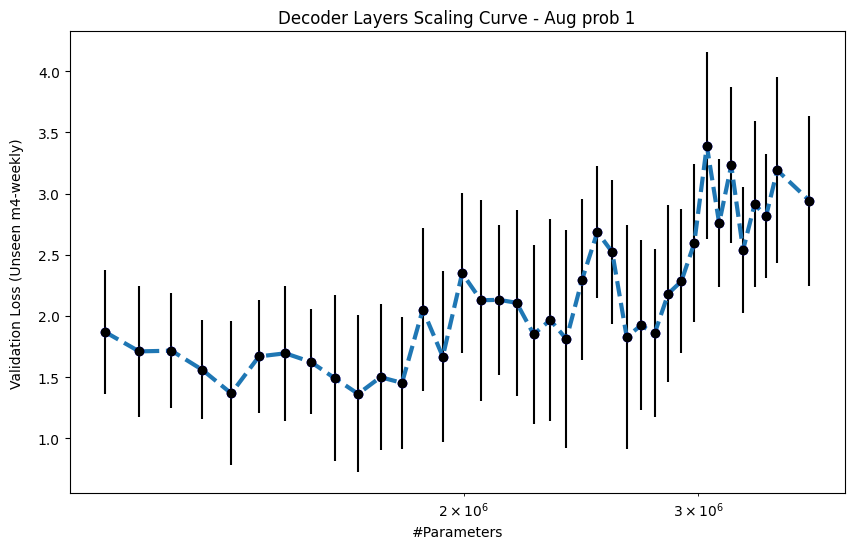

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

# Set figure default figure size
plt.rcParams["figure.figsize"] = (10, 6)

# Values
layers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, \
          22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40]
params_layers = [1074816, 1140480, 1206144, 1271808, 1337472, 1403136, 1468800, 1534464, 1600128, 1665792, 1731456, \
                 1797120, 1862784, 1928448, 1994112, 2059776, 2125440, 2191104, 2256768, 2322432, 2388096, 2453760, \
                 2519424, 2585088, 2650752, 2716416, 2782080, 2847744, 2913408, 2979072, 3044736, 3110400, 3176064, \
                 3241728, 3307392, 3373056, 3438720, 3635712]

groups = []
for layer in layers:
    groups.append("data-scaling-uniform-1.0_augprob_1_layers_"+str(layer))
    
mean_y_layers, stderr_y_layers = get_mean_std_from_csv(groups)

plt.errorbar(params_layers, mean_y_layers, yerr=stderr_y_layers, fmt='o', color="black")
plt.plot(
    params_layers, mean_y_layers, ls="--", lw=3, 
    marker="o", markersize=6, markerfacecolor="blue", markeredgecolor="blue"
)
plt.xlabel("#Parameters")
plt.ylabel("Validation Loss (Unseen m4-weekly)", labelpad=10)
plt.xscale("log")
plt.title("Decoder Layers Scaling Curve - Aug prob 1")
plt.savefig('layers.png')

plt.show()

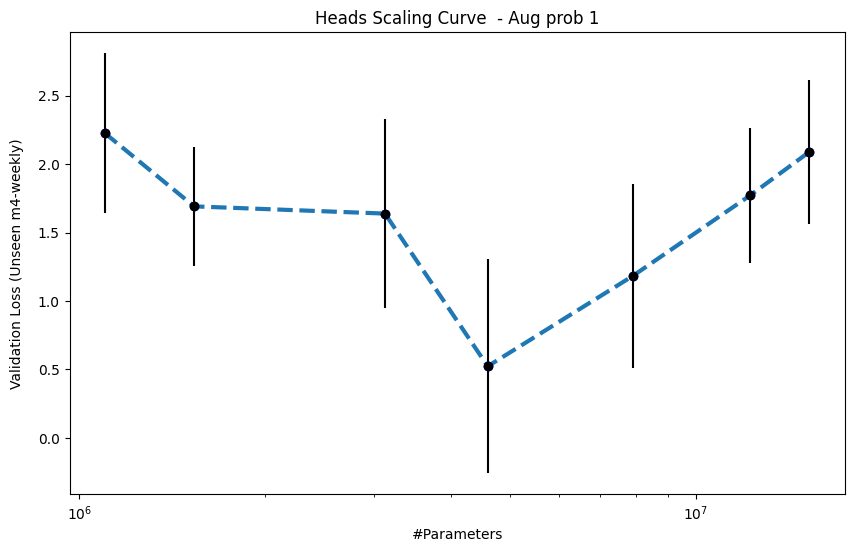

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

# Set figure default figure size
plt.rcParams["figure.figsize"] = (10, 6)

# Values
heads = [1, 4, 8, 12, 16, 20, 24] 
params_heads = [1099392, 1534464, 3130368, 4595200, 7895040, 12243456, \
                15281152]   
# heads = [1, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40] 
# params_heads = [1099392, 1534464, 3130368, 4595200, 7895040, 12243456, \
#                 15281152, 21333504, 28434432, 33044992, 41849856]   


groups = []
for head in heads:
    groups.append("data-scaling-uniform-1.0_augprob_1_heads_"+str(head))
    
mean_y_heads, stderr_y_heads = get_mean_std_from_csv(groups)

plt.errorbar(params_heads, mean_y_heads, yerr=stderr_y_heads, fmt='o', color="black")
plt.plot(
    params_heads, mean_y_heads, ls="--", lw=3, 
    marker="o", markersize=6, markerfacecolor="blue", markeredgecolor="blue"
)
plt.xlabel("#Parameters")
plt.ylabel("Validation Loss (Unseen m4-weekly)", labelpad=10)
plt.xscale("log")
plt.title("Heads Scaling Curve  - Aug prob 1")
plt.savefig('heads.png')

plt.show()

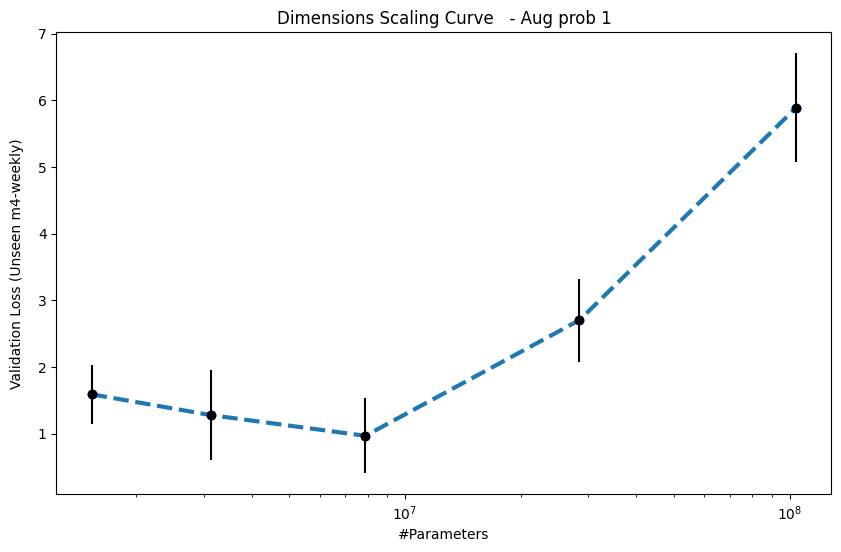

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

# Set figure default figure size
plt.rcParams["figure.figsize"] = (10, 6)

# Values
dims_per_head = [16, 32, 64, 128, 256]
params_dims_per_head = [1534464, 3130368, 7895040, 28434432, 104116224]

groups = []
for dims in dims_per_head:
    groups.append("data-scaling-uniform-1.0_augprob_1_dims_per_head_"+str(dims))
    
mean_y_dims, stderr_y_dims = get_mean_std_from_csv(groups)

plt.errorbar(params_dims_per_head, mean_y_dims, yerr=stderr_y_dims, fmt='o', color="black")
plt.plot(
    params_dims_per_head, mean_y_dims, ls="--", lw=3, 
    marker="o", markersize=6, markerfacecolor="blue", markeredgecolor="blue"
)
plt.xlabel("#Parameters")
plt.ylabel("Validation Loss (Unseen m4-weekly)", labelpad=10)
plt.xscale("log")
plt.title("Dimensions Scaling Curve   - Aug prob 1")
plt.savefig('dims_per_head.png')

plt.show()

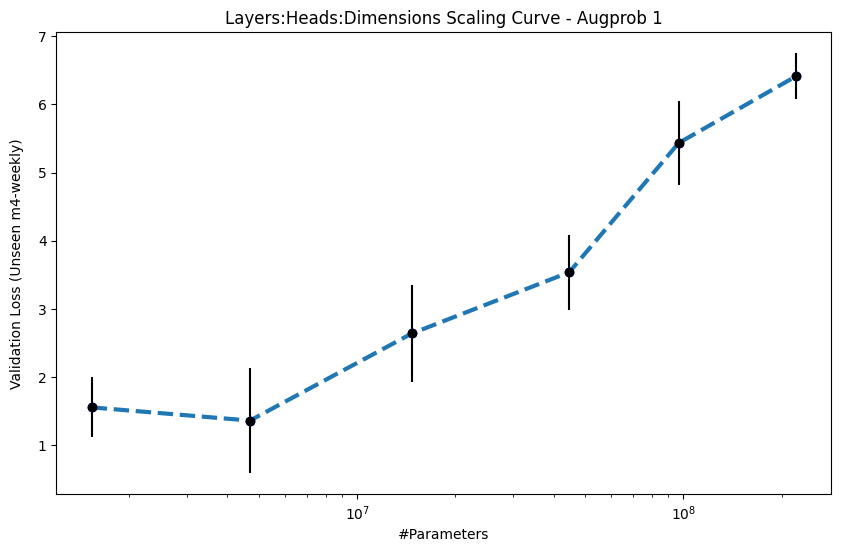

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

# Set figure default figure size
plt.rcParams["figure.figsize"] = (10, 6)

# Values
layers_three_ratio = [8,12,16,20,24,28]
params_three_ratio = [1534464, 4689664, 14714880, 44660736, 96764416, 221874432] 

groups = []
for layer in layers_three_ratio:
    heads = layer // 2
    dims = layer * 2
    groups.append("data-scaling-uniform-1.0_3_ratio_scaling_augprob_1_layers_" + str(layer) + "_heads_" + str(heads) + "_dims_per_head_"+str(dims))
    
mean_y_three_ratio, stderr_y_three_ratio = get_mean_std_from_csv(groups)

plt.errorbar(params_three_ratio, mean_y_three_ratio, yerr=stderr_y_three_ratio, fmt='o', color="black")
plt.plot(
    params_three_ratio, mean_y_three_ratio, ls="--", lw=3, 
    marker="o", markersize=6, markerfacecolor="blue", markeredgecolor="blue"
)
plt.xlabel("#Parameters")
plt.ylabel("Validation Loss (Unseen m4-weekly)", labelpad=10)
plt.xscale("log")
plt.title("Layers:Heads:Dimensions Scaling Curve - Augprob 1")
plt.savefig('layers:heads:dimensions.png')

plt.show()

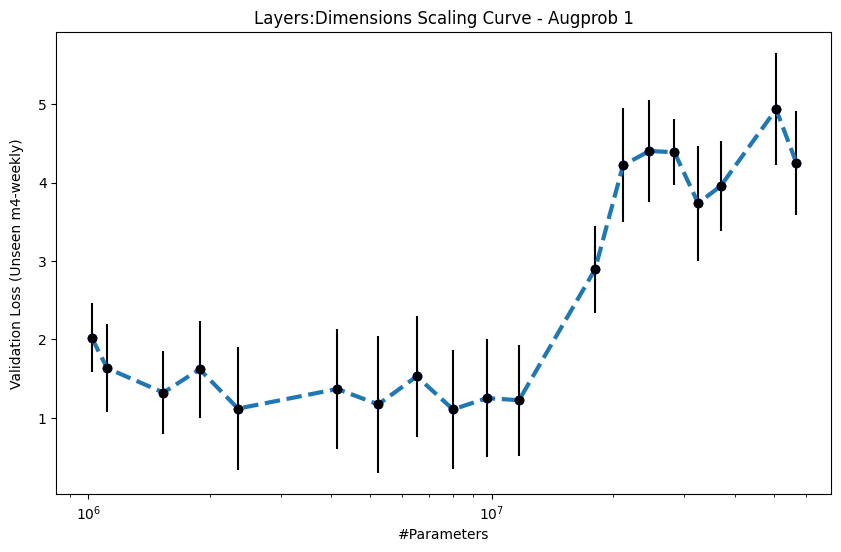

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

# Set figure default figure size
plt.rcParams["figure.figsize"] = (10, 6)

# Values
layers_dims_ratio = [2,4,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
params_layers_dims_ratio = [1019328, 1113088, 1534464, 1886656, 2349568, 4139712, 5229568, 6516160, 8011776, 9728704, \
                            11679232, 18028992, 21147136, 24584896, 28354560, 32468416, 36938752, 50649792, 56828416]

groups = []
for layer in layers_dims_ratio:
    dims = layer * 2
    groups.append("data-scaling-uniform-1.0_augprob_1_layers_dims_per_head_ratio_scaling_layers_" + str(layer) + "_dims_per_head_"+str(dims))
    
mean_y_layers_dims_ratio, stderr_y_layers_dims_ratio = get_mean_std_from_csv(groups)

plt.errorbar(params_layers_dims_ratio, mean_y_layers_dims_ratio, yerr=stderr_y_layers_dims_ratio, fmt='o', color="black")
plt.plot(
    params_layers_dims_ratio, mean_y_layers_dims_ratio, ls="--", lw=3, 
    marker="o", markersize=6, markerfacecolor="blue", markeredgecolor="blue"
)
plt.xlabel("#Parameters")
plt.ylabel("Validation Loss (Unseen m4-weekly)", labelpad=10)
plt.xscale("log")
plt.title("Layers:Dimensions Scaling Curve - Augprob 1")
plt.savefig('layers:dimensions.png')

plt.show()

# All Curves in One Plot

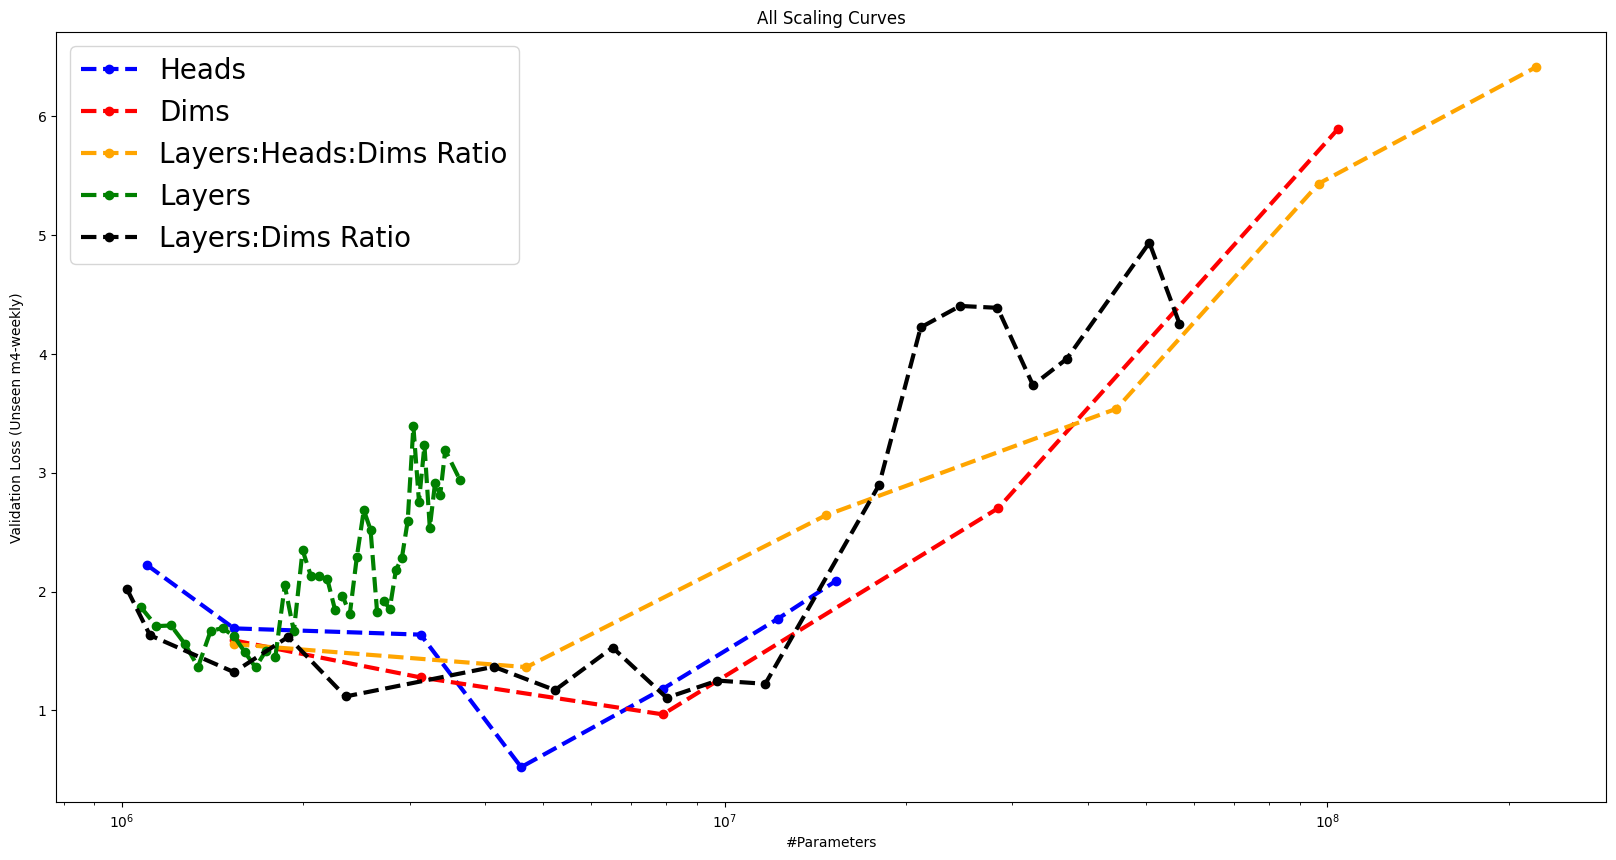

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

# Set figure default figure size
plt.rcParams["figure.figsize"] = (20, 10)

# plt.errorbar(params_heads, mean_y_heads, yerr=stderr_y_heads, fmt='o', color="black")
plt.plot(
    params_heads, mean_y_heads, ls="--", lw=3, color="blue", 
    marker="o", markersize=6, markerfacecolor="blue", markeredgecolor="blue", label="Heads"
)
# plt.errorbar(params_dims, mean_y_dims, yerr=stderr_y_dims, fmt='o', color="black")
plt.plot(
    params_dims_per_head, mean_y_dims, ls="--", lw=3, color="red", 
    marker="o", markersize=6, markerfacecolor="red", markeredgecolor="red", label="Dims"
)
# plt.errorbar(params_ratio, mean_y_ratio, yerr=stderr_y_ratio, fmt='o', color="black")
plt.plot(
    params_three_ratio, mean_y_three_ratio, ls="--", lw=3, color="orange",
    marker="o", markersize=6, markerfacecolor="orange", markeredgecolor="orange", label="Layers:Heads:Dims Ratio"
)
# plt.errorbar(params_ratio, mean_y_ratio, yerr=stderr_y_ratio, fmt='o', color="black")
plt.plot(
    params_layers, mean_y_layers, ls="--", lw=3, color="green",
    marker="o", markersize=6, markerfacecolor="green", markeredgecolor="green", label="Layers"
)
# plt.errorbar(params_ratio, mean_y_ratio, yerr=stderr_y_ratio, fmt='o', color="black")
plt.plot(
    params_layers_dims_ratio, mean_y_layers_dims_ratio, ls="--", lw=3, color="black",
    marker="o", markersize=6, markerfacecolor="black", markeredgecolor="black", label="Layers:Dims Ratio"
)
plt.legend(prop = { "size": 20 })
plt.xlabel("#Parameters")
plt.ylabel("Validation Loss (Unseen m4-weekly)", labelpad=10)
plt.xscale("log")
plt.title("All Scaling Curves")
plt.savefig('all-curves-scaling.png')

plt.show()

# All Models

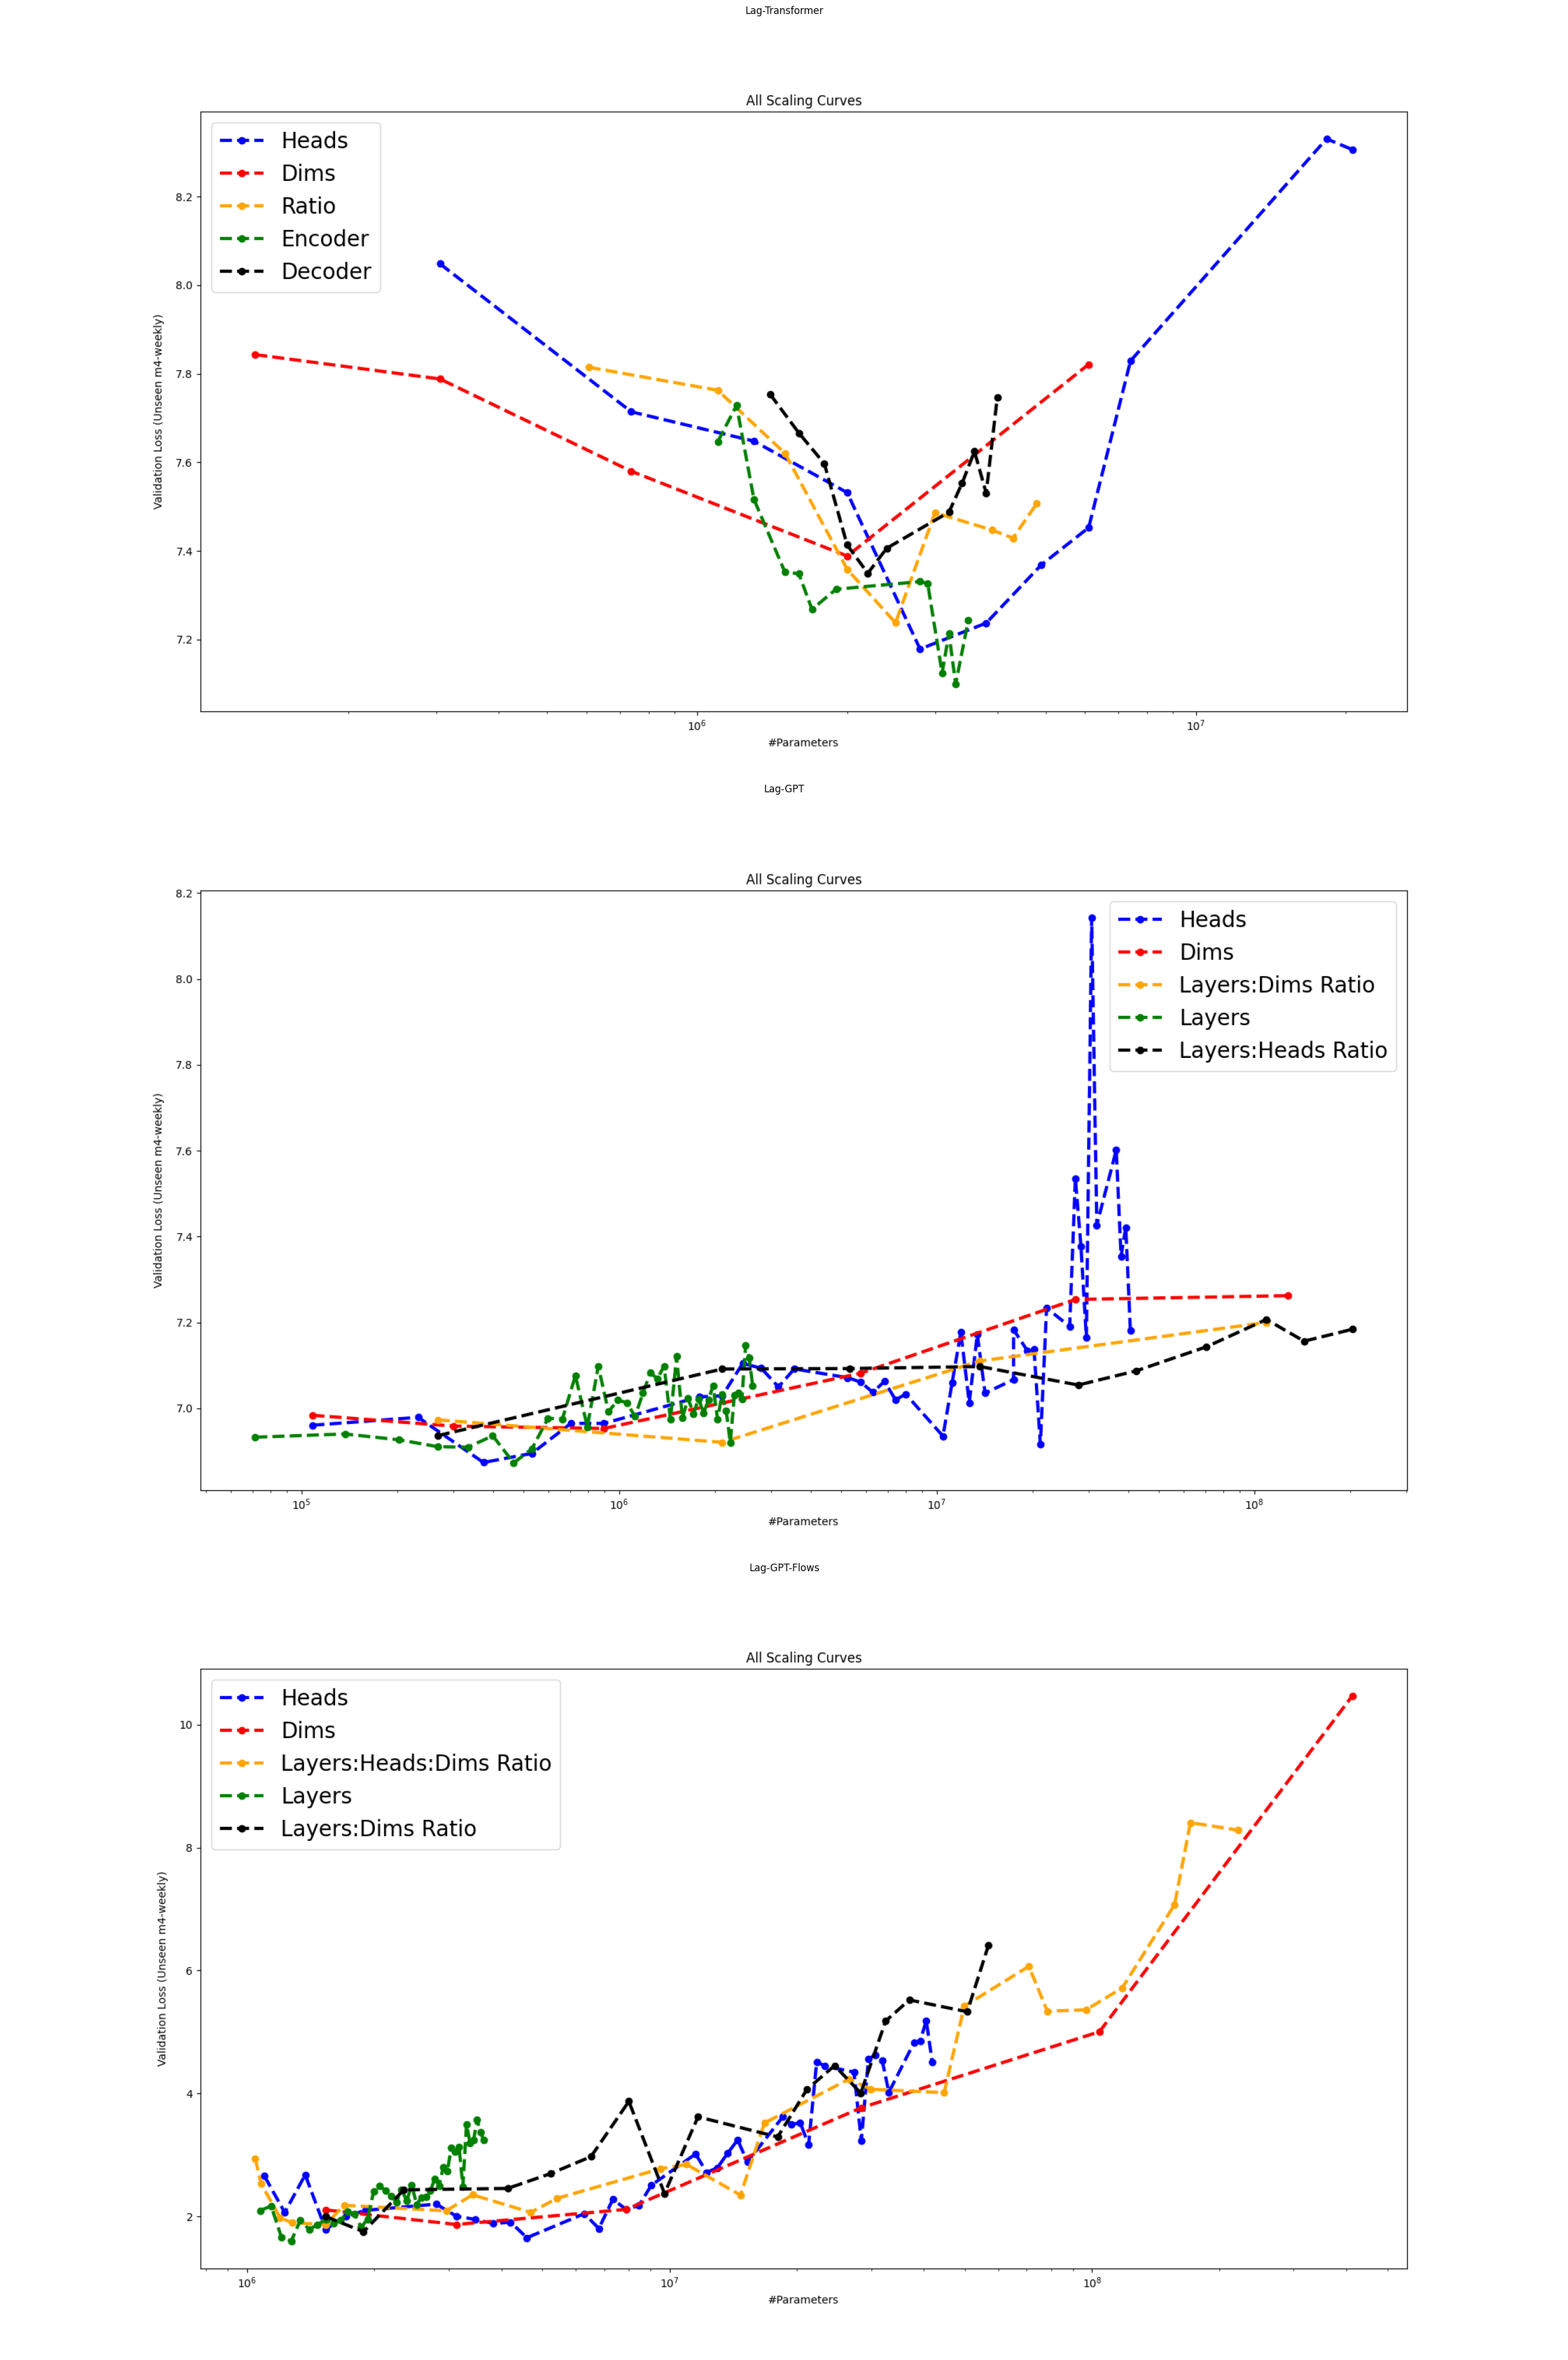

In [40]:
from PIL import Image
import matplotlib.pyplot as plt

# Replace these filenames with the actual paths and filenames of your PNG images
image1 = Image.open("/home/toolkit/pytorch-transformer-ts/lag-transformer/all-curves-scaling.png")
image2 = Image.open("/home/toolkit/pytorch-transformer-ts/lag-gpt/all-curves-scaling.png")
image3 = Image.open("/home/toolkit/pytorch-transformer-ts/lag-gpt-flows/all-curves-scaling.png")

# Create a figure and three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40, 40), sharex=True, sharey=True)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0)

# Turn off axis ticks and labels for all subplots
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Display the images on each subplot
ax1.imshow(image1)
ax2.imshow(image2)
ax3.imshow(image3)

# Add titles to the subplots
title_fontsize = 20
ax1.set_title("Lag-Transformer")
ax2.set_title("Lag-GPT")
ax3.set_title("Lag-GPT-Flows")

# Show the plot
plt.show()